# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1  # Bessel function

# Parametres systeme

In [2]:
f2 = 150   # en mm, lentille extérieure
na = 0.4   # aperture

lamb = 405  # en nm, laser bleu
M_theo = 20
pixel_size = 3.45  # en um, x et y
cam_width = 1440
cam_height = 1080

poisson_lamb = 400

M = (150 * M_theo) / 160

pxl = pixel_size / M  # en um

pixel_size = 3.45  # en um, x et y
cam_width = 1440
cam_height = 1080

# Paramètres de la simulation
f2 = 150  # Facteur de l'objectif
na = 0.4  # Numerical aperture
lamb = 0.405  # Wavelength in um
M_theo = 20  # Magnification of the objective
poisson_lamb = 400  # Average number of photons
mean_photon_count = 5  # Mean number of photons emitted

In [3]:
x = np.arange(cam_width)
y = np.arange(cam_height)
X, Y = np.meshgrid(x, y)

mean_photon_count = 5  # Average photons per pixel
intensity_grid = np.random.poisson(mean_photon_count, (cam_height, cam_width))

# Code PSF

In [4]:
def psf(xx, yy, particle_pos, na, lamb, effective_pixel_size):
    # s'assurer que tout est en um
    px, py = particle_pos
    x_um = (xx - px) * effective_pixel_size
    y_um = (yy - py) * effective_pixel_size
    r = np.sqrt(x_um**2 + y_um**2)  # Distance en um

    # Wave vector
    k = 2 * np.pi * na / (lamb)  # Wavelength en um

    # Airy disk
    psf = np.zeros_like(r)
    nonzero_indices = r > 0
    psf[nonzero_indices] = ((2 * j1(k * r[nonzero_indices]) / (k * r[nonzero_indices])) ** 2)
    psf[r == 0] = 1  # traitement de la singularite

    return psf

# 1re figure

In [5]:
# Number of points to select
num_points = 5

# Randomly select indices
random_x = np.random.choice(x, num_points)
random_y = np.random.choice(y, num_points)

# Combine into coordinates
random_points = np.column_stack((random_x, random_y))
random_points

array([[  68,   94],
       [1076, 1059],
       [1047,  698],
       [1237,  915],
       [ 858, 1077]])

In [6]:
for i, value in enumerate(random_points):
    particle_loc = value
    psf_values = psf(X, Y, particle_loc, na, lamb, pxl)
    
    # somme des probas à 1
    psf_values /= psf_values.sum()
    psf_flat = psf_values.flatten()
    
    # Simulate photon count based on Poisson distribution
    num_simulations = np.random.poisson(poisson_lamb)
    for _ in range(num_simulations):
        index = np.random.choice(len(psf_flat), p=psf_flat)
        
        random_x = X.flatten()[index]
        random_y = Y.flatten()[index]
        
        # Find the nearest grid indices
        grid_x_idx = np.argmin(np.abs(x - random_x))
        grid_y_idx = np.argmin(np.abs(y - random_y))
        
        # Count photon emission
        intensity_grid[grid_y_idx, grid_x_idx] += 1

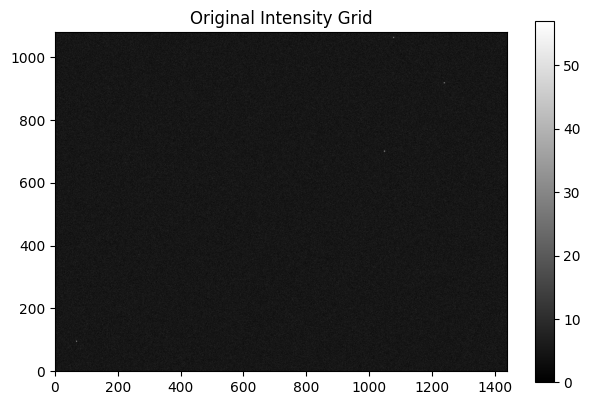

In [7]:
plt.figure(figsize=(12, 4))

# Original intensity grid with a cross at the mean of the Gaussian (from the fit)
plt.subplot(1, 2, 1)
plt.imshow(intensity_grid, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='gray')
plt.title('Original Intensity Grid')
plt.colorbar()
plt.tight_layout()
plt.savefig("heatmap.png", dpi=300, bbox_inches='tight')

In [8]:
from PIL import Image

data = intensity_grid

normalized_data = (255 * (data - np.min(data)) / (np.max(data) - np.min(data))).astype(np.uint8)

# Save as TIFF
Image.fromarray(normalized_data).save("microscope_image.tiff")

# Next images

In [9]:
def Deplacement_brownien(particule_loc, sigma, n_steps):
    dx = np.random.normal(0, sigma, n_steps)
    dy = np.random.normal(0, sigma, n_steps)
    positions = np.cumsum(np.array([dx, dy]), axis=1).T + np.array(particule_loc)
    return positions

In [10]:
D = 2.196338215 * 10**(-13) # m^2/s
nb_steps = 10
duree_totale = 10
delta_t = duree_totale/nb_steps
variance = np.sqrt(2*D*delta_t)*10**(6) # um
pxl = pixel_size / (f2 * M_theo / 160)  # Pixel size in um
variance_px = variance / pxl  # Variance in pixels

In [11]:
lst = []
for i in range(num_points):
    lst.append(Deplacement_brownien(random_points[i], variance_px, nb_steps))

In [12]:
lst

[array([[62.56181418, 92.50044011],
        [66.17234183, 88.60599478],
        [69.88494167, 87.83968021],
        [66.55448732, 89.83424462],
        [67.31582384, 91.03845629],
        [66.25518684, 87.39074285],
        [69.02918476, 94.68391421],
        [68.33350951, 93.72226213],
        [70.22400587, 89.7884296 ],
        [70.41989921, 90.71722306]]),
 array([[1077.73198914, 1050.54397575],
        [1077.38855525, 1051.42972576],
        [1080.61505931, 1043.46258609],
        [1074.0997774 , 1033.93223181],
        [1070.39278226, 1030.28732532],
        [1071.83596702, 1027.474459  ],
        [1076.34680874, 1024.93195812],
        [1080.7776343 , 1018.59435054],
        [1075.52335701, 1020.58732436],
        [1072.36784249, 1018.26754769]]),
 array([[1041.32984244,  698.56439467],
        [1036.25224782,  698.43920029],
        [1033.62633152,  696.86087519],
        [1028.01837437,  699.0478898 ],
        [1029.48835266,  701.20882612],
        [1030.74957296,  694.7335137